In [9]:
from keras import optimizers, losses
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Lambda, Dense, Input, Dropout, Embedding, LSTM
from keras.optimizers import RMSprop, Adam, Nadam
from keras.preprocessing import sequence
from keras.losses import mse, binary_crossentropy

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score

In [3]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [19]:
class Visualization:
    labels = ["Normal", "Anomaly"]
    
    def draw_confusion_matrix(self,y,ypred):
        matrix = confusion_matrix(y,ypred)
        plt.figure(figsize=(10,8))
        colors = ["orange","green"]
        sns.heatmap(matrix,xticklabels=self.labels,yticklabels=self.labels,
                   cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel('Actual')
        plt.xlabel('Predicted')
        
    def draw_anomaly(self,y,error,threshold):
        groupsDF = pd.DataFrame({'error': error,'true': y}).groupby('true')
        
        figure, axes = plt.subplots(figsize=(12,8))
        
        for name, group in groupsDF:
            axes.plot(group.index, group.error, marker='x' if name == 1 
                      else 'o', linestyle='', color='r' if name == 1
                     else 'g', label="Anomaly" if name==1 else "Normal")
        
        axes.hlines(threshold,axes.get_xlim()[0],axes.get_xlim()[1],colors="b",
                   zorder=100,label='Threshold')
        axes.legend()
        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        
    def draw_error(self,error,threshold):
        plt.plot(error,marker='o',ms=3.5,linestyle='',label='Point')
        
        plt.hlines(threshold,xmin=0,xmax=len(error)-1,colors="b",zorder=100,
                  label='Threshold')
        plt.legend()
        plt.title("Reconstruction error")
        plt.ylabel("Error")
        plt.xlabel("Data")

In [5]:
df = pd.read_csv('C:/Users/timsh/.spyder-py3/credit_card.csv')

In [6]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df0 = df.query('Class==0').sample(20000)
df1 = df.query('Class==1').sample(400)
df = pd.concat([df0,df1])

In [8]:
x_train,x_test,y_train,y_test = train_test_split(df.drop(labels=['Time','Class'],axis=1),
                                                df['Class'],test_size=0.2,random_state=42)

In [10]:
# reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch,dim))
    return z_mean + K.exp(0.5*z_log_var)*epsilon

In [11]:
original_dim = x_train.shape[1]
print(original_dim)

input_shape = (original_dim,)
intermediate_dim = 12 # encode 29 columns of input into 12 features
batch_size = 32
latent_dim = 2 # two parallel layers
epochs = 20

# VAE model = encoder + decoder
# build encoder model

inputs = Input(shape=input_shape,name='encoder_input')
x = Dense(intermediate_dim,activation='relu')(inputs)
z_mean = Dense(latent_dim,name='z_mean')(x)
z_log_var = Dense(latent_dim,name='z_log_var')(x)

z = Lambda(sampling,output_shape=(latent_dim,),name='z')([z_mean,z_log_var])

# instantiate encoder model
encoder = Model(inputs,[z_mean,z_log_var,z],name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,),name='z_sampling')
x = Dense(intermediate_dim,activation='relu')(latent_inputs)
outputs = Dense(original_dim,activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs,outputs,name='decoder')
decoder.summary()

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs,outputs,name='vae_mlp')

# VAE Loss
reconstruction_loss = mse(inputs,outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

29
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 29)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 12)           360         encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            26          dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            26          dense_1[0][0]                    
_________________________________________________________________________________________

In [12]:
# compile the model using adam
# Adam is an optimization algorithm that can be used instead of the classical SGD procedure
# to update network weights iteratively
vae.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])
vae.summary()

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 29)                0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 412       
_________________________________________________________________
decoder (Model)              (None, 29)                413       
Total params: 825
Trainable params: 825
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = vae.fit(x_train,x_train,batch_size=batch_size,epochs=epochs,verbose=1,
                 shuffle=True,validation_data=(x_test,x_test))

Train on 16320 samples, validate on 4080 samples
Epoch 1/20
16320/16320 [==============================] - 1s 51us/step - loss: 51.4281 - accuracy: 0.0859 - val_loss: 46.5529 - val_accuracy: 0.1017
Epoch 2/20
16320/16320 [==============================] - 1s 34us/step - loss: 47.7466 - accuracy: 0.1211 - val_loss: 45.6452 - val_accuracy: 0.1257
Epoch 3/20
16320/16320 [==============================] - 1s 34us/step - loss: 47.3216 - accuracy: 0.1350 - val_loss: 45.4167 - val_accuracy: 0.1397
Epoch 4/20
16320/16320 [==============================] - 1s 33us/step - loss: 47.1532 - accuracy: 0.1546 - val_loss: 45.2769 - val_accuracy: 0.1691
Epoch 5/20
16320/16320 [==============================] - 1s 34us/step - loss: 47.0385 - accuracy: 0.1833 - val_loss: 45.2041 - val_accuracy: 0.1924
Epoch 6/20
16320/16320 [==============================] - 1s 34us/step - loss: 46.9808 - accuracy: 0.2162 - val_loss: 45.0794 - val_accuracy: 0.2495
Epoch 7/20
16320/16320 [==============================] -

In [15]:
score = vae.evaluate(x_test,x_test,verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4080/4080 [==============================] - 0s 13us/step
Test loss: 44.25501521989411
Test accuracy: 0.3446078300476074


In [16]:
threshold= 10.00
y_pred = vae.predict(x_test)
y_dist = np.linalg.norm(x_test - y_pred, axis=-1)
z = zip(y_dist >= threshold, y_dist)
y_label = []
error = []
for idx, (is_anomaly, y_dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(y_dist)

In [17]:
roc_auc_score(y_test,y_label)

0.8795561380939666

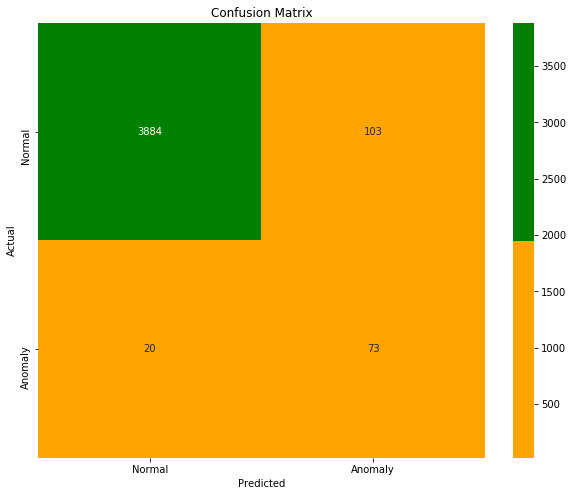

In [20]:
viz = Visualization()
viz.draw_confusion_matrix(y_test,y_label)

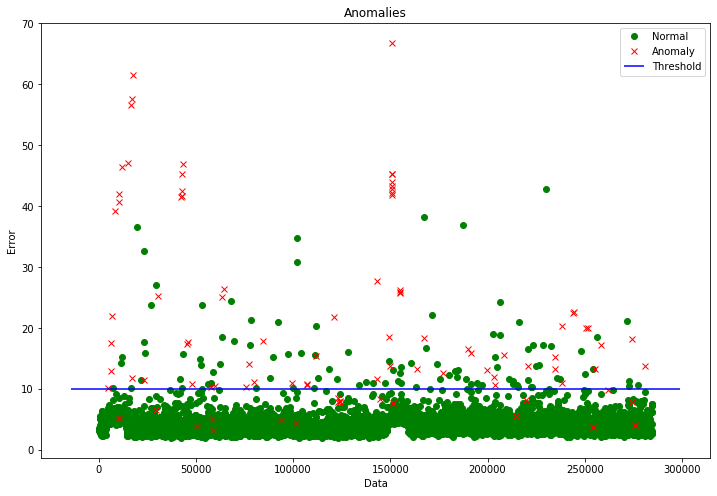

In [21]:
viz.draw_anomaly(y_test,error,threshold)